Avacado Project
Problem Statement:
Avocado is a fruit consumed by people heavily in the United States. 

Content
This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. 

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. 

Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. 

The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

Date - The date of the observation
AveragePrice - the average price of a single avocado
type - conventional or organic
year - the year
Region - the city or region of the observation
Total Volume - Total number of avocados sold
4046 - Total number of avocados with PLU 4046 sold
4225 - Total number of avocados with PLU 4225 sold
4770 - Total number of avocados with PLU 4770 sold


Inspiration /Label 

Your task is to make a mode that can consider the data provided and predict the Average Price.

In [1]:
#common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Preprecessing Lib
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

#outliars and skewness
from scipy import stats
from sklearn.preprocessing import power_transform

#multicoliniarity lib
from statsmodels.stats.outliers_influence import variance_inflation_factor

#model lib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR

#Model Evaluation
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

#model cross validation
from sklearn.model_selection import cross_val_score


#Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the dataset into dataframe
df=pd.read_csv('avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
#checking the shape of dataframe
df.shape
#the data frame has 18249 rows and 14 columns

(18249, 14)

In [4]:
#this is basically used to display the complete row of dataframe
pd.set_option('display.max_rows',None)

In [5]:
df.info()
#Here there is no null value in any of the columns and there datatypes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [6]:
#checking the null value in the dataframe
df.isna().sum()
#there is no null value is present in the dataframe.

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

<AxesSubplot:>

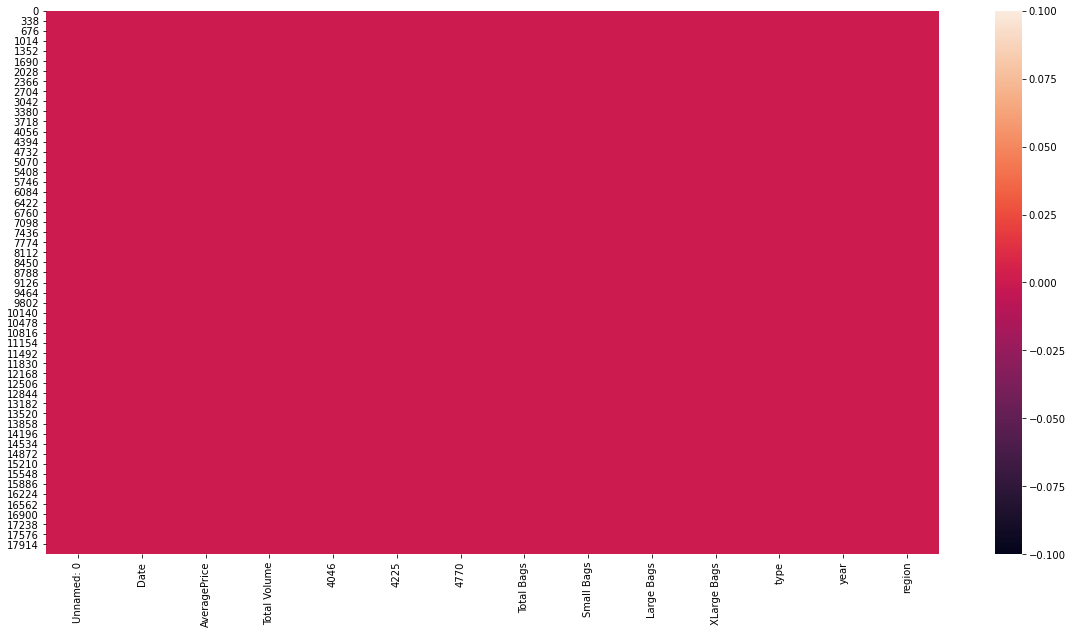

In [7]:
#plotting the heatmap to check the null value.
plt.figure(figsize=(20,10))
sns.heatmap(df.isna())

In [3]:
#here the one columns is unwanted 'Unnamed: 0' so we can delete that column.
df=df.drop(columns='Unnamed: 0',axis=1)

In [4]:
#Since Total Volume & Total Bags are just the total of 4046, 4225, 4770 & Small/Large/XLarge Bags will calculate the percentage of these columns and drop the individual columns
df["4046_perc"] = df["4046"]/df["Total Volume"] * 100
df["4225_perc"] = df["4225"]/df["Total Volume"] * 100
df["4770_perc"] = df["4770"]/df["Total Volume"] * 100
df["Small_Bags_perc"] = df["Small Bags"]/df["Total Bags"] * 100
df["Large_Bags_perc"] = df["Large Bags"]/df["Total Bags"] * 100
df["XLarge_Bags_perc"] = df["XLarge Bags"]/df["Total Bags"] * 100
df = df.drop(df[["4046", "4225", "4770","Small Bags","Large Bags","XLarge Bags"]],  axis=1)
df.head()

,Date,AveragePrice,Total Volume,Total Bags,type,year,region,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,XLarge_Bags_perc
0,2015-12-27,1.33,64236.62,8696.87,conventional,2015,Albany,1.613939,84.772284,0.074973,98.927775,1.072225,0.0
1,2015-12-20,1.35,54876.98,9505.56,conventional,2015,Albany,1.228712,81.343416,0.106292,98.974390,1.025610,0.0
2,2015-12-13,0.93,118220.22,8145.35,conventional,2015,Albany,0.672220,92.327412,0.110387,98.733756,1.266244,0.0
3,2015-12-06,1.08,78992.15,5811.16,conventional,2015,Albany,1.433054,91.118434,0.091883,97.698222,2.301778,0.0
4,2015-11-29,1.28,51039.60,6183.95,conventional,2015,Albany,1.844607,85.890936,0.148473,96.803176,3.196824,0.0


In [10]:
#checking the null value
df.isna().sum()

Date                 0
AveragePrice         0
Total Volume         0
Total Bags           0
type                 0
year                 0
region               0
4046_perc            0
4225_perc            0
4770_perc            0
Small_Bags_perc     15
Large_Bags_perc     15
XLarge_Bags_perc    15
dtype: int64

In [5]:
#fill NA without mean() value
df['Small_Bags_perc']=df['Small_Bags_perc'].fillna(df['Small_Bags_perc'].mean())
df['Large_Bags_perc']=df['Large_Bags_perc'].fillna(df['Large_Bags_perc'].mean())
df['XLarge_Bags_perc']=df['XLarge_Bags_perc'].fillna(df['XLarge_Bags_perc'].mean())

In [12]:
#checking the null value
df.isna().sum()

Date                0
AveragePrice        0
Total Volume        0
Total Bags          0
type                0
year                0
region              0
4046_perc           0
4225_perc           0
4770_perc           0
Small_Bags_perc     0
Large_Bags_perc     0
XLarge_Bags_perc    0
dtype: int64

In [16]:
#Now using the encoding technique to encode the catagorical feature data.
#the features are Date,type,year,region which having the catogorical data.
#Date: label Encoder then get_dummies
#type: label Encoder
#years:label Encoder then get_dummies
#region:label Encoder then get_dummies

In [6]:
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df['Date']=df['Date'].map(dt.datetime.toordinal)
df.head()

,Date,AveragePrice,Total Volume,Total Bags,type,year,region,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,XLarge_Bags_perc
0,735959,1.33,64236.62,8696.87,conventional,2015,Albany,1.613939,84.772284,0.074973,98.927775,1.072225,0.0
1,735952,1.35,54876.98,9505.56,conventional,2015,Albany,1.228712,81.343416,0.106292,98.974390,1.025610,0.0
2,735945,0.93,118220.22,8145.35,conventional,2015,Albany,0.672220,92.327412,0.110387,98.733756,1.266244,0.0
3,735938,1.08,78992.15,5811.16,conventional,2015,Albany,1.433054,91.118434,0.091883,97.698222,2.301778,0.0
4,735931,1.28,51039.60,6183.95,conventional,2015,Albany,1.844607,85.890936,0.148473,96.803176,3.196824,0.0


In [7]:
#Using the get dummy method for the encoding
df=pd.get_dummies(df,columns=['type','region'],drop_first=True)
df.head()

,Date,AveragePrice,Total Volume,Total Bags,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,735959,1.33,64236.62,8696.87,2015,1.613939,84.772284,0.074973,98.927775,1.072225,...,0,0,0,0,0,0,0,0,0,0
1,735952,1.35,54876.98,9505.56,2015,1.228712,81.343416,0.106292,98.974390,1.025610,...,0,0,0,0,0,0,0,0,0,0
2,735945,0.93,118220.22,8145.35,2015,0.672220,92.327412,0.110387,98.733756,1.266244,...,0,0,0,0,0,0,0,0,0,0
3,735938,1.08,78992.15,5811.16,2015,1.433054,91.118434,0.091883,97.698222,2.301778,...,0,0,0,0,0,0,0,0,0,0
4,735931,1.28,51039.60,6183.95,2015,1.844607,85.890936,0.148473,96.803176,3.196824,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df.iloc[:,:10].head()

,Date,AveragePrice,Total Volume,Total Bags,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc
0,735959,1.33,64236.62,8696.87,2015,1.613939,84.772284,0.074973,98.927775,1.072225
1,735952,1.35,54876.98,9505.56,2015,1.228712,81.343416,0.106292,98.974390,1.025610
2,735945,0.93,118220.22,8145.35,2015,0.672220,92.327412,0.110387,98.733756,1.266244
3,735938,1.08,78992.15,5811.16,2015,1.433054,91.118434,0.091883,97.698222,2.301778
4,735931,1.28,51039.60,6183.95,2015,1.844607,85.890936,0.148473,96.803176,3.196824


In [16]:
#checking the new shape of dataframe
df.shape
#the new shape has 18249 rows and 235 columns

(18249, 65)

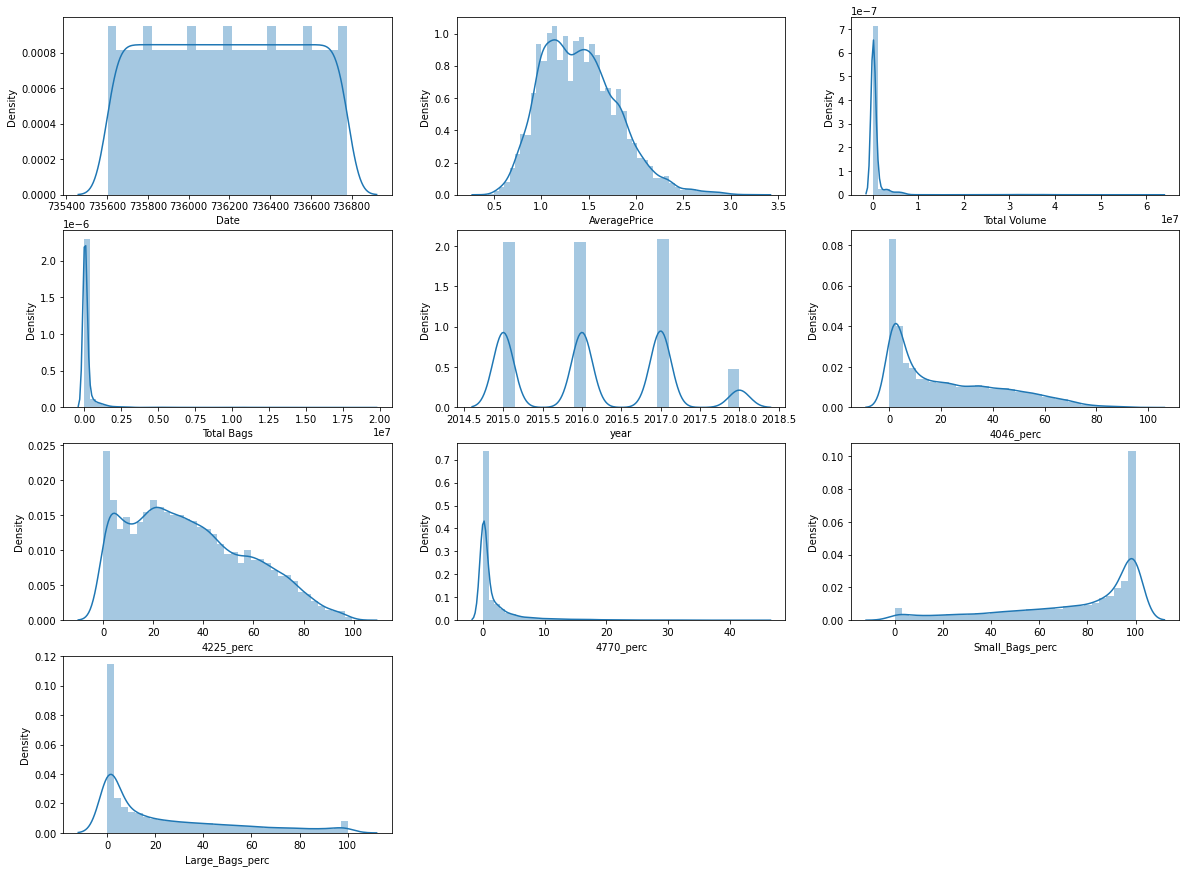

In [17]:
#ploting the distribition plot to check the data distribution
plt.figure(figsize=(20,15),facecolor='white')
pltnum=1

for column in df.iloc[:,:10]:
    if pltnum <= 30:
        plt.subplot(4,3,pltnum)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=10)
        
    pltnum +=1
plt.show()    

In [ ]:
#we can see there is outilers in all the features.

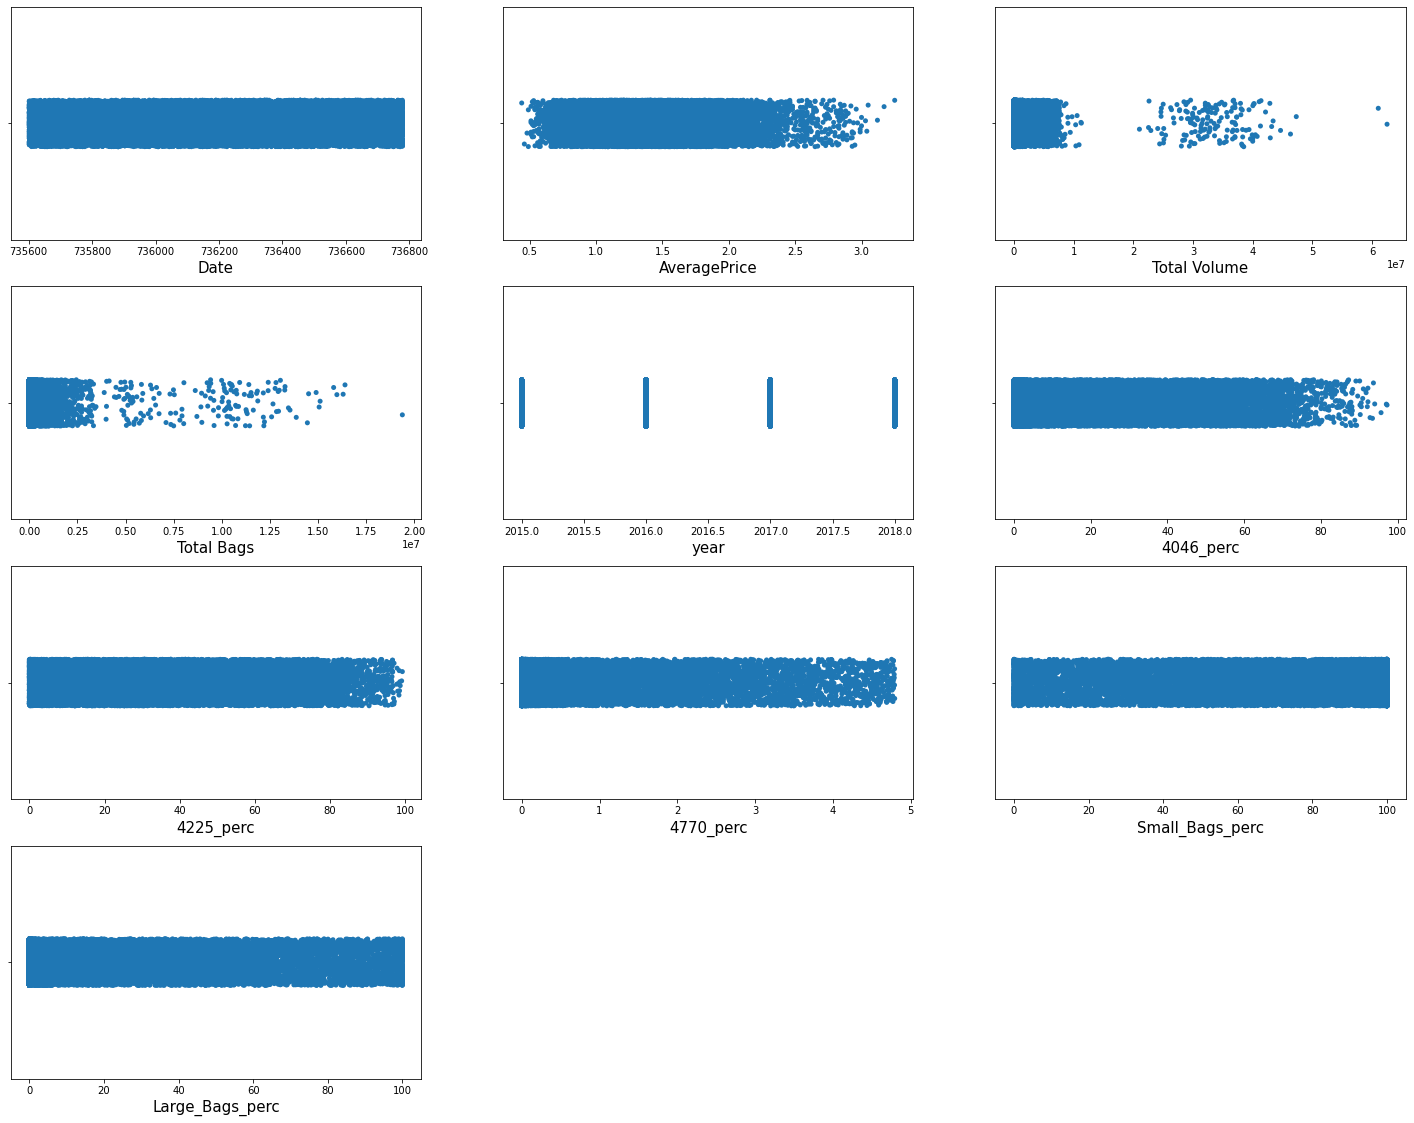

In [22]:
#checking the data distrubution using the distribution plot.
plt.figure(figsize=(25,30),facecolor='white')
pltnum=1

for column in df.iloc[:,:10]:
    if pltnum <= 18:
        plt.subplot(6,3,pltnum)
        sns.stripplot(df[column])
        plt.xlabel(column,fontsize=15)
        
    pltnum +=1
plt.show()    

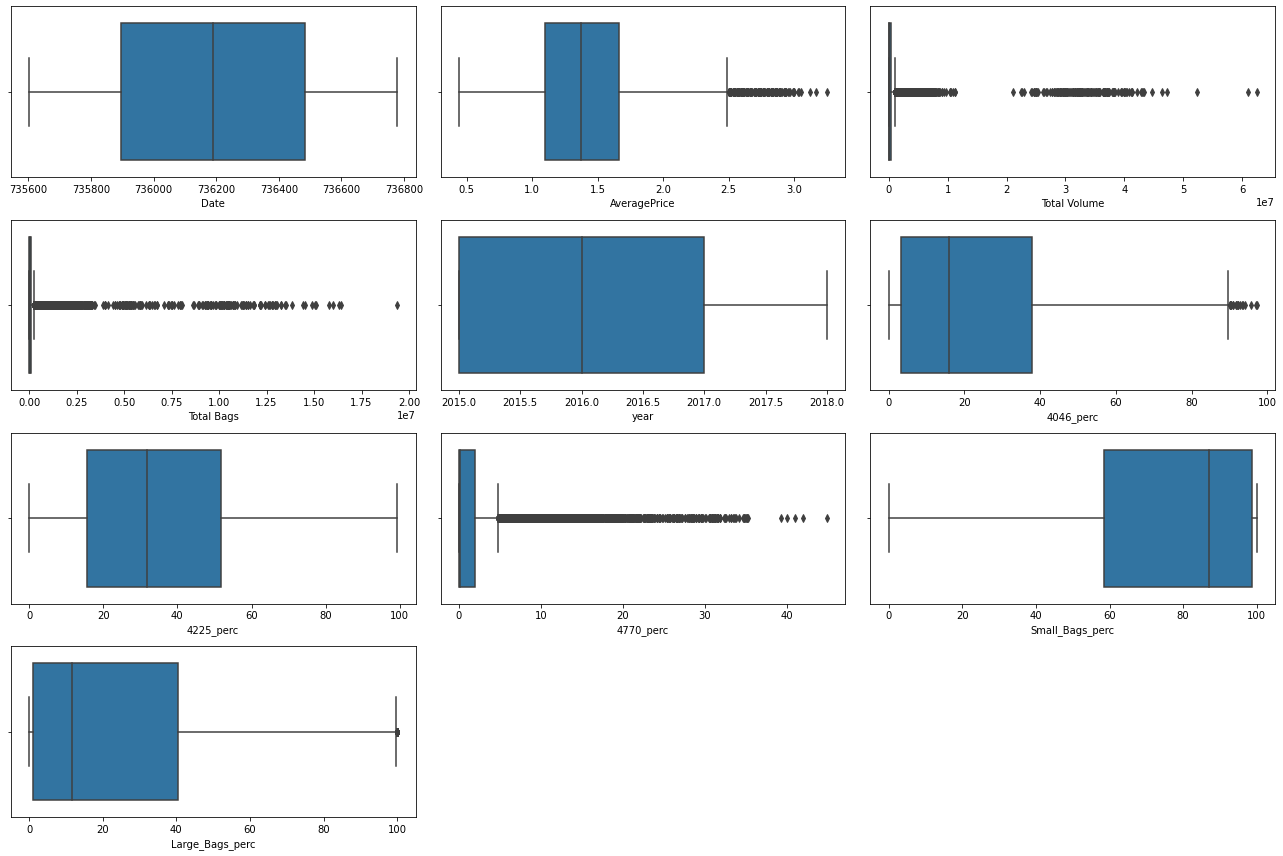

In [18]:
#Checking the Ouliars using boxplot:
plt.figure(figsize=(18,12),facecolor='white')
pltnum=1

for columns in df.iloc[:,:10]:
    if pltnum <= 16:
        plt.subplot(4,3,pltnum)
        sns.boxplot(df[columns])
        plt.xlabel(columns,fontsize=10)
        
    pltnum +=1
plt.tight_layout()    

In [8]:
#Checking the IQR method:
q1=df.iloc[:,[2,3,5,7]].quantile(0.25)

q3=df.iloc[:,[2,3,5,7]].quantile(0.75)

iqr=q3-q1

In [9]:
for column in df.iloc[:,[2,3,5,7]]:
    index1=np.where(df[column] > (q3[column] +(1.5 * iqr[column])))

In [10]:
df=df.drop(df.index[index1])
df.reset_index()

,index,Date,AveragePrice,Total Volume,Total Bags,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,0,735959,1.33,64236.62,8696.87,2015,1.613939,84.772284,0.074973,98.927775,...,0,0,0,0,0,0,0,0,0,0
1,1,735952,1.35,54876.98,9505.56,2015,1.228712,81.343416,0.106292,98.974390,...,0,0,0,0,0,0,0,0,0,0
2,2,735945,0.93,118220.22,8145.35,2015,0.672220,92.327412,0.110387,98.733756,...,0,0,0,0,0,0,0,0,0,0
3,3,735938,1.08,78992.15,5811.16,2015,1.433054,91.118434,0.091883,97.698222,...,0,0,0,0,0,0,0,0,0,0
4,4,735931,1.28,51039.60,6183.95,2015,1.844607,85.890936,0.148473,96.803176,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16069,18243,736736,1.57,15986.17,12693.57,2018,12.037155,8.559399,0.000000,97.981498,...,0,0,0,0,0,0,0,0,0,1
16070,18244,736729,1.63,17074.83,13498.67,2018,11.988172,8.955872,0.000000,96.800796,...,0,0,0,0,0,0,0,0,0,1
16071,18245,736722,1.71,13888.04,9264.84,2018,8.580764,24.708310,0.000000,96.494273,...,0,0,0,0,0,0,0,0,0,1
16072,18247,736708,1.93,16205.22,10969.54,2018,9.426777,18.395554,4.486270,99.544192,...,0,0,0,0,0,0,0,0,0,1


In [12]:
#checking the ss
df.shape

(16074, 65)

In [13]:
#Data Loss in percentage
loss_percentage=(18249-16074)/18249*100
print(loss_percentage)

11.918461285549894


In [14]:
#As only data loss is only 11.91% after the outliers deletion it can be work because for z-score data loss is only 2% and complere
#outliers are not delted in z-score.

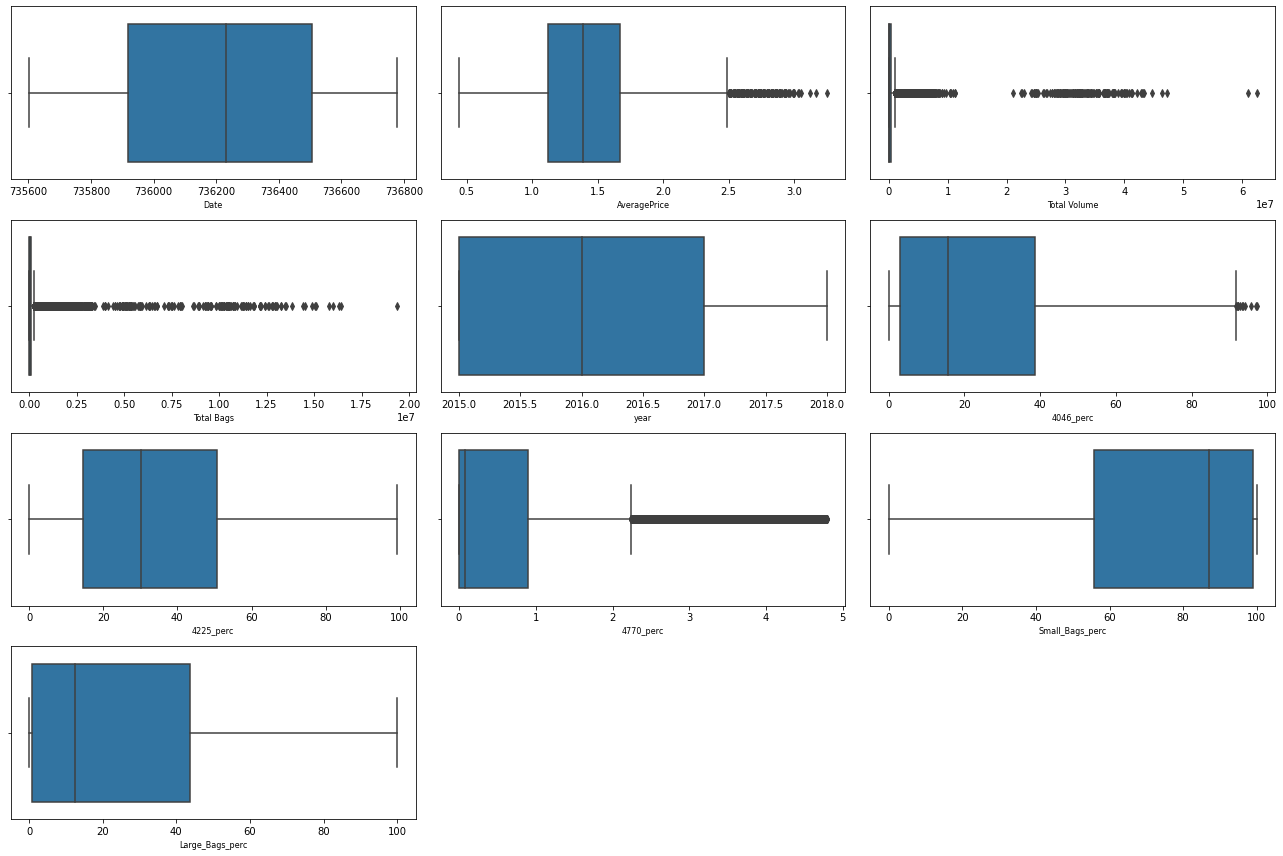

In [15]:
#Checking the Ouliars using boxplot:
plt.figure(figsize=(18,12),facecolor='white')
pltnum=1

for columns in df.iloc[:,:10]:
    if pltnum <= 16:
        plt.subplot(4,3,pltnum)
        sns.boxplot(df[columns])
        plt.xlabel(columns,fontsize=8)
        
    pltnum +=1
plt.tight_layout()    

In [25]:
#still the outliers is visible.not we can ckeck the skewness and correlation in to features.

In [16]:
corr_df=df.iloc[:,:10].abs().corr()
corr_df['AveragePrice'].sort_values(ascending=False)

AveragePrice       1.000000
4225_perc          0.165119
Date               0.128626
Small_Bags_perc    0.122909
year               0.076382
Large_Bags_perc   -0.116274
Total Bags        -0.179256
Total Volume      -0.192033
4770_perc         -0.298718
4046_perc         -0.339773
Name: AveragePrice, dtype: float64

In [ ]:
#There is no skewness is shown in the features as the range is in between -0.5 to +0.5.

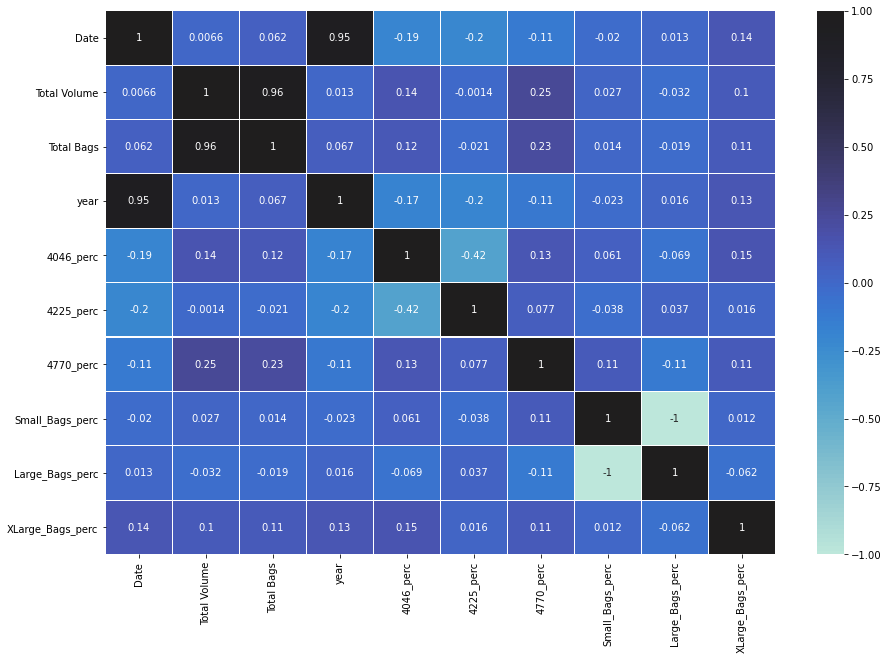

In [27]:
#using the heatmap to check the multicolliniarity between the features.
corr_matrix=df.iloc[:,[0,2,3,4,5,6,7,8,9,10]].abs().corr()

plt.figure(figsize=(15,10))

sns.heatmap(corr_matrix,vmin=-1,vmax=1,center=True,annot=True, fmt='.2g',linewidths=0.1)
plt.show()
#Total Bags,Total Volume

In [ ]:
#There is a strong co-relation between ( Total Volume & Total Bags), (year & Date), (Large_Bags_perc & Small_Bags_perc). Also, data in total bags and total volume are redundant data. 
#checking the same with the vif

In [19]:
x_tst=df.iloc[:,[0,2,3,4,5,6,7,8,9,10]]

In [20]:
#checking vif score beofore standred scalar.
def CalculateVIF(Data):
    vif = dict()
    vif["FeatureColumns"] = Data.columns
    vif["VIF"] = [variance_inflation_factor(Data.values, i) for i in range(Data.shape[1])]
    return(pd.DataFrame(vif))

In [21]:
CalculateVIF(x_tst)
#there is multicolliniarity issue looks in features.now checking the same with after scalar.

,FeatureColumns,VIF
0,Date,1.041401e+01
1,Total Volume,1.427872e+01
2,Total Bags,1.413615e+01
3,year,1.023780e+01
4,4046_perc,1.471656e+00
5,4225_perc,1.411103e+00
6,4770_perc,1.120510e+00
7,Small_Bags_perc,3.746038e+06
8,Large_Bags_perc,8.973969e+05
9,XLarge_Bags_perc,1.440614e+03


In [23]:
fea_data=['Total Volume','4046_perc','4225_perc','4770_perc','Total Bags','Small_Bags_perc','Large_Bags_perc','XLarge_Bags_perc','year','Date']
features = df[fea_data]

In [24]:
#performing the standerd scalar for scaling the data
scalar=StandardScaler()
x_new=scalar.fit_transform(features.values)

In [25]:
#allling the scaled data to df
df[['Total Volume','4046_perc','4225_perc','4770_perc','Total Bags','Small_Bags_perc','Large_Bags_perc','XLarge_Bags_perc','year','Date']]=x_new

In [26]:
df.head()

,Date,AveragePrice,Total Volume,Total Bags,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,-0.738998,1.33,-0.220823,-0.230031,-1.2799,-0.967464,2.120442,-0.544222,0.844882,-0.828152,...,0,0,0,0,0,0,0,0,0,0
1,-0.759480,1.35,-0.223463,-0.229237,-1.2799,-0.985148,1.977264,-0.516426,0.846465,-0.829731,...,0,0,0,0,0,0,0,0,0,0
2,-0.779962,0.93,-0.205595,-0.230572,-1.2799,-1.010695,2.435920,-0.512792,0.838294,-0.821576,...,0,0,0,0,0,0,0,0,0,0
3,-0.800444,1.08,-0.216660,-0.232864,-1.2799,-0.975768,2.385437,-0.529215,0.803133,-0.786480,...,0,0,0,0,0,0,0,0,0,0
4,-0.820925,1.28,-0.224545,-0.232498,-1.2799,-0.956875,2.167154,-0.478992,0.772741,-0.756145,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#putting the features into seprate dataframe for which we have to check the multicollinearity issue.
x_n=df.iloc[:,[0,2,3,4,5,6,7,8,9,10]]
x_n.head()

,Date,Total Volume,Total Bags,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,XLarge_Bags_perc
0,-0.738998,-0.220823,-0.230031,-1.2799,-0.967464,2.120442,-0.544222,0.844882,-0.828152,-0.300918
1,-0.759480,-0.223463,-0.229237,-1.2799,-0.985148,1.977264,-0.516426,0.846465,-0.829731,-0.300918
2,-0.779962,-0.205595,-0.230572,-1.2799,-1.010695,2.435920,-0.512792,0.838294,-0.821576,-0.300918
3,-0.800444,-0.216660,-0.232864,-1.2799,-0.975768,2.385437,-0.529215,0.803133,-0.786480,-0.300918
4,-0.820925,-0.224545,-0.232498,-1.2799,-0.956875,2.167154,-0.478992,0.772741,-0.756145,-0.300918


In [28]:
#again using vif for checking the multicollinearity between the colums after scalar.
vif=pd.DataFrame()
vif['features']=x_n.columns
vif['vif score']=[variance_inflation_factor(x_new,i) for i in range(x_new.shape[1])]
vif

,features,vif score
0,Date,1.427872e+01
1,Total Volume,1.471695e+00
2,Total Bags,1.411137e+00
3,year,1.120534e+00
4,4046_perc,1.413615e+01
5,4225_perc,7.304161e+10
6,4770_perc,7.331271e+10
7,Small_Bags_perc,1.862240e+08
8,Large_Bags_perc,1.023795e+01
9,XLarge_Bags_perc,1.041424e+01


In [29]:
#from VIF also we can see that #There is a strong co-relation between ( Total Volume & Total Bags), (year & Date), (Large_Bags_perc & Small_Bags_perc).
#Also, data in total bags and total volume are redundant data.

In [30]:
##Dropping the 'Total Volume' and 'Total Bags' and again checking the vif.
x_n=x_n.drop(columns=['Total Volume','Total Bags'],axis=1)
x_n.head()

,Date,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,XLarge_Bags_perc
0,-0.738998,-1.2799,-0.967464,2.120442,-0.544222,0.844882,-0.828152,-0.300918
1,-0.759480,-1.2799,-0.985148,1.977264,-0.516426,0.846465,-0.829731,-0.300918
2,-0.779962,-1.2799,-1.010695,2.435920,-0.512792,0.838294,-0.821576,-0.300918
3,-0.800444,-1.2799,-0.975768,2.385437,-0.529215,0.803133,-0.786480,-0.300918
4,-0.820925,-1.2799,-0.956875,2.167154,-0.478992,0.772741,-0.756145,-0.300918


In [31]:
#again using vif for checking the multicollinearity between the colums
def CalculateVIF(Data):
    vif = dict()
    vif["FeatureColumns"] = Data.columns
    vif["VIF"] = [variance_inflation_factor(Data.values, i) for i in range(Data.shape[1])]
    return(pd.DataFrame(vif))

In [32]:
CalculateVIF(x_n)

,FeatureColumns,VIF
0,Date,1.040436e+01
1,year,1.022618e+01
2,4046_perc,1.446194e+00
3,4225_perc,1.404023e+00
4,4770_perc,1.061461e+00
5,Small_Bags_perc,7.304161e+10
6,Large_Bags_perc,7.331271e+10
7,XLarge_Bags_perc,1.862237e+08


In [33]:
#performing the test_train_split without deleting any featueres
#the results are:
#LR=66.26%  Cross Validation Score=36.00%
#KNN=83.63%  Cross Validation Score=12.93%
#RFR=85.97%  Cross Validation Score=-2.31%	
#ADA=44.29%  Cross Validation Score=-23.33%
#SVR=79.90%  Cross Validation Score=41.68%

In [34]:
#seprating the features and labels/targets to check multicolliniarity between features
x=df.drop(columns='AveragePrice',axis=1)
y=df['AveragePrice']

In [35]:
x=x.drop(columns=['Total Volume','Total Bags'],axis=1)
x.head()

,Date,year,4046_perc,4225_perc,4770_perc,Small_Bags_perc,Large_Bags_perc,XLarge_Bags_perc,type_organic,region_Atlanta,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,-0.738998,-1.2799,-0.967464,2.120442,-0.544222,0.844882,-0.828152,-0.300918,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.759480,-1.2799,-0.985148,1.977264,-0.516426,0.846465,-0.829731,-0.300918,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.779962,-1.2799,-1.010695,2.435920,-0.512792,0.838294,-0.821576,-0.300918,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.800444,-1.2799,-0.975768,2.385437,-0.529215,0.803133,-0.786480,-0.300918,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.820925,-1.2799,-0.956875,2.167154,-0.478992,0.772741,-0.756145,-0.300918,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#Finding best Random State:
maxAcc=0
maxRs=0

for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=i)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    y_pred=lr.predict(x_test)
    acc_r2=r2_score(y_test,y_pred)
    if acc_r2 > maxAcc:
        maxAcc=acc_r2
        maxRs=i
        
print(f"Best Accuracy is : {maxAcc* 100:.2f}%")
print("The Best Random State is :",maxRs)     

Best Accuracy is : 66.64%
The Best Random State is : 98


In [37]:
#seprating the train and test datasets with the best find random state
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=98)

In [38]:
#model Evaluation for LR:
print('\n==========Model Evaluaton and Accuracy check using LinearRegression===========')
lr=LinearRegression()
lr.fit(x_train,y_train)
y_predlr=lr.predict(x_test)
print(f"The accuracy of the model using LinearRegression is: {r2_score(y_test,y_predlr)*100:.2f}%\n")



#model Evaluation for KNN:
print('\n==========Model Evaluaton and Accuracy check using KNeighborsRegressor===========')
knn=KNeighborsRegressor()
knn.fit(x_train,y_train)
y_predknn=knn.predict(x_test)
print(f"The accuracy of the model using KNeighborsRegressor is: {r2_score(y_test,y_predknn)*100:.2f}%\n")



#model Evaluation for RandomForestRegressor:
print('\n==========Model Evaluaton and Accuracy check using RandomForestRegressor===========')
rfr=RandomForestRegressor()
rfr.fit(x_train,y_train)
y_predrfr=rfr.predict(x_test)
print(f"The accuracy of the model using RandomForestRegressor is: {r2_score(y_test,y_predrfr)*100:.2f}%\n")



#model Evaluation for AdaBoostRegressor:
print('\n==========Model Evaluaton and Accuracy check using AdaBoostRegressor===========')
ada=AdaBoostRegressor()
ada.fit(x_train,y_train)
y_predada=ada.predict(x_test)
print(f"The accuracy of the model using AdaBoostRegressor is: {r2_score(y_test,y_predada)*100:.2f}%\n")



#model Evaluation for SVR:
#print('\n===============Model Evaluaton and Accuracy check using SVR====================')
#svr=SVR()
#svr.fit(x_train,y_train)
#y_predsvr=svr.predict(x_test)
#print(f"The accuracy of the model using SVR is: {r2_score(y_test,y_predsvr)*100:.2f}%\n")


==========Model Evaluaton and Accuracy check using LinearRegression===========
The accuracy of the model using LinearRegression is: 66.64%


==========Model Evaluaton and Accuracy check using KNeighborsRegressor===========
The accuracy of the model using KNeighborsRegressor is: 83.84%


==========Model Evaluaton and Accuracy check using RandomForestRegressor===========
The accuracy of the model using RandomForestRegressor is: 90.01%


==========Model Evaluaton and Accuracy check using AdaBoostRegressor===========
The accuracy of the model using AdaBoostRegressor is: 59.85%



In [39]:
print('\n=============Cross Validation Score of Linear Reggression==============')
cvs_lr=cross_val_score(lr,x,y,cv=5)
print(f"Cross validation for the Linear Reggression is: {cvs_lr.mean()*100:.2f}%\n")

print('\n=============Cross Validation Score of KNeighborsRegressor==============')
cvs_knn=cross_val_score(knn,x,y,cv=5)
print(f"Cross validation for the KNeighborsRegressor is: {cvs_knn.mean()*100:.2f}%\n")

print('\n==========Cross Validation Score of Random Forest Regressor===========')
cvs_rfr=cross_val_score(rfr,x,y,cv=5)
print(f"Cross validation for the Random Forest Regressor is: {cvs_rfr.mean()*100:.2f}%\n")

print('\n============Cross Validation Score of AdaBoostRegressor===================')
cvs_ada=cross_val_score(ada,x,y,cv=5)
print(f"Cross validation for the AdaBoostRegressor is: {cvs_ada.mean()*100:.2f}%\n")

#print('\n===================Cross Validation Score of SVR========================')
#cvs_svr=cross_val_score(svr,x,y,cv=5)
#print(f"Cross validation for the KNN Classifier is: {cvs_svr.mean()*100:.2f}%\n")


=============Cross Validation Score of Linear Reggression==============
Cross validation for the Linear Reggression is: 34.21%


=============Cross Validation Score of KNeighborsRegressor==============
Cross validation for the KNeighborsRegressor is: -62.84%


==========Cross Validation Score of Random Forest Regressor===========
Cross validation for the Random Forest Regressor is: 56.31%


============Cross Validation Score of AdaBoostRegressor===================
Cross validation for the AdaBoostRegressor is: 24.73%



In [40]:
#Now checking the Regularation process using Lasso,Ridge,ElasticNet 

In [41]:
#Regularation Process
from sklearn.linear_model import Lasso,Ridge,ElasticNet

In [42]:
# Lasso model
print('\n==========Accuracy of Lasso===========')
le=Lasso(alpha=0.0001)
le.fit(x_train,y_train)
predictlasso = le.predict(x_test)
le.score(x_train,y_train)
print(f"The accuracy of the model using Lasso is: {r2_score(y_test,predictlasso)*100:.2f}%\n")


# Ridge model
print('\n==========Accuracy of Ridge===========')
rg =Ridge(alpha=0.0001)
rg.fit(x_train,y_train)
rg.score(x_train,y_train)
predictridge = rg.predict(x_test)
print(f"The accuracy of the model using Ridge is: {r2_score(y_test,predictridge)*100:.2f}%\n")


# Elastic model
print('\n==========Accuracy of Elastic===========')
el=ElasticNet(alpha=0.0001)
el.fit(x_train,y_train)
el.score(x_train,y_train)
predictel = el.predict(x_test)
print(f"The accuracy of the model using ElasticNet is: {r2_score(y_test,predictel)*100:.2f}%\n")


==========Accuracy of Lasso===========
The accuracy of the model using Lasso is: 66.52%


==========Accuracy of Ridge===========
The accuracy of the model using Ridge is: 66.64%


==========Accuracy of Elastic===========
The accuracy of the model using ElasticNet is: 66.59%



In [43]:
print('\n==========Cross Validation Score of Lasso===========')
cvs_le=cross_val_score(le,x,y,cv=5)
print(f"Cross validation for the LASSO is: {cvs_le.mean()*100:.2f}%\n")

print('\n==========Cross Validation Score of Ridge===========')
cvs_rg=cross_val_score(rg,x,y,cv=5)
print(f"Cross validation for the Ridge is: {cvs_rg.mean()*100:.2f}%\n")


print('\n==========Cross Validation Score of ElasticNet===========')
cvs_el=cross_val_score(el,x,y,cv=5)
print(f"Cross validation for the ElasticNet is: {cvs_el.mean()*100:.2f}%\n")


==========Cross Validation Score of Lasso===========
Cross validation for the LASSO is: 34.93%


==========Cross Validation Score of Ridge===========
Cross validation for the Ridge is: 34.22%


==========Cross Validation Score of ElasticNet===========
Cross validation for the ElasticNet is: 34.79%



In [ ]:
#As we can see that the result of r2 accuracy and cross validation score of all the models.
#LinearReggression:66.64%
#Cross Validation Score:34.21%
#Diffrence:32.43

#KNeighborsRegressor:83.84%
#Cross Validation Score:-62.84%
#Diffrence:146.68

#Random Forest Regressor:90.04%
#Cross Validation Score:56.33%
#Diffrence:33.71

#AdaBoostRegressor:59.18%
#Cross Validation Score:24.52%
#Diffrence:33.66

#LASSO:66.52%
#Cross Validation Score:34.93%
#Diffrence:31.59

#Ridge:66.64%
#Cross Validation Score:34.22%
#Diffrence:32.42

#ElasticNet:66.59%
#Cross Validation Score:34.79%
#Diffrence:31.8

In [ ]:
#As we can see that the Random Forest Regressor is best here with least diffrence and highest accuracy.
#So we will use Random Forest Regressor for the hyper parameter tuning.

In [44]:
#Now Appling the gridsearchcv beofore building the model to check the best parameter.
best_param={'n_estimators':[90,100,110],
           'max_depth':[10,12,15],
           'min_samples_split':[2,3,5],
           'min_samples_leaf':[2,4,6]}

In [45]:
gridcv=GridSearchCV(rfr,param_grid=best_param)

In [46]:
gridcv.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 12, 15],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [90, 100, 110]})

In [48]:
gridcv.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 110}

In [53]:
#model Evaluation for RandomForestRegressor:
print('\n==========Model Evaluaton and Accuracy check using RandomForestRegressor===========')
rfr=RandomForestRegressor(max_depth=22,min_samples_leaf=4,min_samples_split=3,n_estimators=200)
rfr.fit(x_train,y_train)
y_predrfr=rfr.predict(x_test)
print(f"The accuracy of the model using RandomForestRegressor is: {r2_score(y_test,y_predrfr)*100:.2f}%\n")


==========Model Evaluaton and Accuracy check using RandomForestRegressor===========
The accuracy of the model using RandomForestRegressor is: 88.24%



In [ ]:
#as we can see after peroforming the hyper parameter tuning the accuracy got reduced so we will not perfrom the hyper parameter
#tuning

In [54]:
#model Evaluation for RandomForestRegressor:
print('\n==========Model Evaluaton and Accuracy check using RandomForestRegressor===========')
rfr=RandomForestRegressor()
rfr.fit(x_train,y_train)
y_predrfr=rfr.predict(x_test)
print(f"The accuracy of the model using RandomForestRegressor is: {r2_score(y_test,y_predrfr)*100:.2f}%\n")


==========Model Evaluaton and Accuracy check using RandomForestRegressor===========
The accuracy of the model using RandomForestRegressor is: 90.06%



In [ ]:
#Saving the model

In [55]:
#Saving the model
import pickle
filename = 'avocado_Model.pkl'
pickle.dump(rfr, open(filename, 'wb'))

In [ ]:
#this complete the our model building.